# Teeth Disease Prediction

### 1 - Import Libraries & Load the Dataset

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

In [ ]:
!unzip -q "/content/Teeth DataSet.zip" -d "/content"

In [ ]:
# Dataset Paths
main_dir = 'Teeth_Dataset'

train_dir = os.path.join(main_dir, 'Training')
test_dir = os.path.join(main_dir, 'Testing')
val_dir = os.path.join(main_dir, 'Validation')

### 2 - Visualization

In [ ]:

def count_images_per_class(dataset_dir, set_type):
    cls_labels = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

    image_counts = {
        folder: len([
            f for f in os.listdir(os.path.join(dataset_dir, folder))
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        for folder in cls_labels
    }


    plt.figure(figsize=(10, 5))
    plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.title(f"Number of Images per Class in {set_type} Set")
    plt.xticks(rotation=45)
    plt.show()
    return image_counts

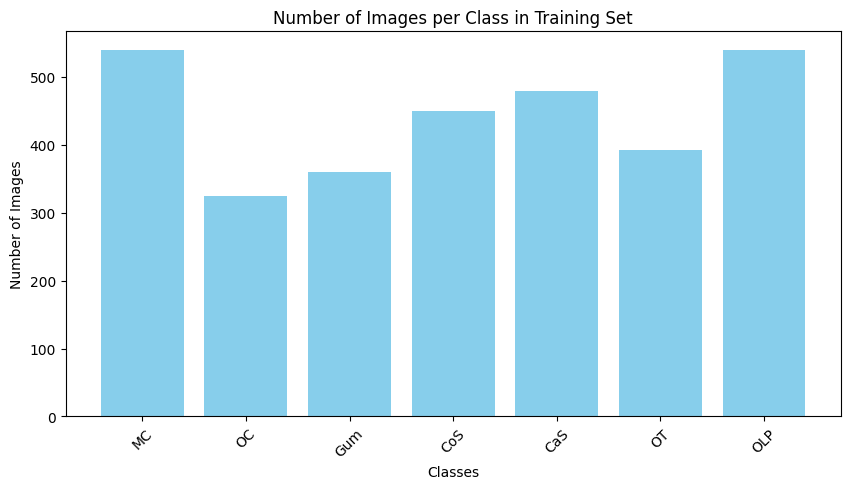

{'MC': 540,
 'OC': 324,
 'Gum': 360,
 'CoS': 450,
 'CaS': 480,
 'OT': 393,
 'OLP': 540}

In [ ]:
count_images_per_class(train_dir, 'Training')

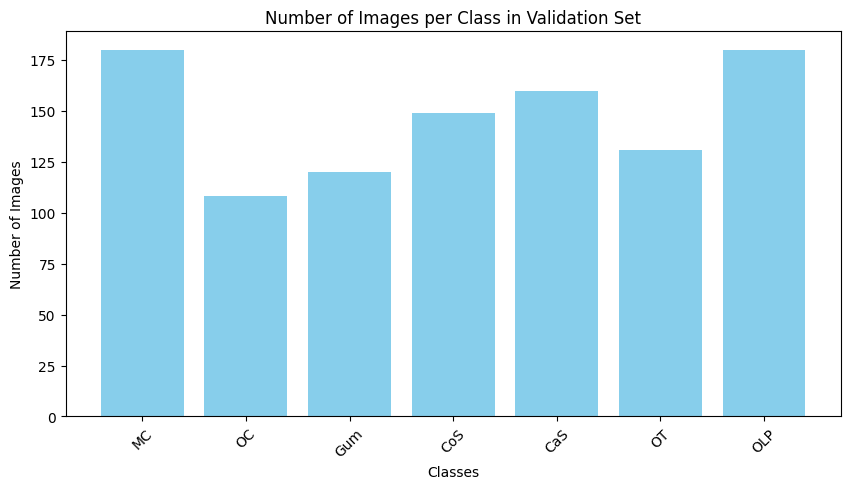

{'MC': 180,
 'OC': 108,
 'Gum': 120,
 'CoS': 149,
 'CaS': 160,
 'OT': 131,
 'OLP': 180}

In [ ]:
count_images_per_class(val_dir, 'Validation')

### 3- Augmentation

In [ ]:
train_datagen = ImageDataGenerator(

    rescale=1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range= 0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(
    rescale=1/255.
)

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size = IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


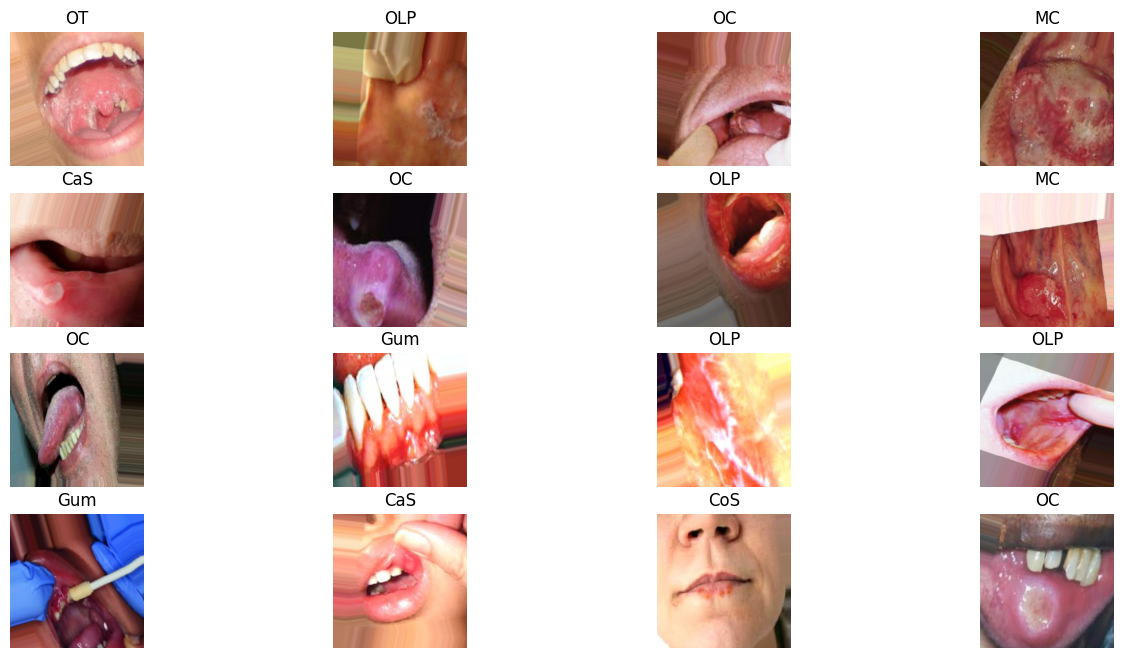

In [ ]:
class_names = ['CaS', 'CoS', 'Gum','MC','OC','OLP','OT']

def visualize_augmentation(generator):
    augmented_image, label = next(train_generator)
    plt.figure(figsize=(16,8))

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_image[i])
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")

    plt.show()

visualize_augmentation(train_generator)

### 4- Model Architecture and Training


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Activation

model = Sequential()

# First Conv
model.add(Conv2D(32, (3,3), padding="same", input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# Second Conv
model.add(Conv2D(64, (3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# Third Conv
model.add(Conv2D(128, (3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten & Fully Connected Layers
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(7, activation="softmax"))


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,940,743 (49.37 MB)

 Trainable params: 12,940,039 (49.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# ModelCheckpoint: Save the model after every epoch.
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'teeth_classification.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

In [ ]:
# Reduce learning rate when metric stopped improving.
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [ ]:
history = model.fit(train_generator, validation_data=val_generator, epochs=70,  callbacks=[checkpoint, early_stopping, reduce_lr_on_plateau])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 56s 518ms/step - accuracy: 0.2953 - loss: 1.9943 - val_accuracy: 0.1449 - val_loss: 2.9482 - learning_rate: 0.0010
Epoch 2/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 76s 484ms/step - accuracy: 0.4505 - loss: 1.4608 - val_accuracy: 0.1479 - val_loss: 3.1729 - learning_rate: 0.0010
Epoch 3/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 49s 504ms/step - accuracy: 0.4976 - loss: 1.3402 - val_accuracy: 0.1975 - val_loss: 2.6470 - learning_rate: 0.0010
Epoch 4/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 499ms/step - accuracy: 0.5469 - loss: 1.1999 - val_accuracy: 0.2879 - val_loss: 2.5191 - learning_rate: 0.0010
Epoch 5/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 500ms/step - accuracy: 0.5523 - loss: 1.1916 - val_accuracy: 0.4835 - val_loss: 1.3681 - learning_rate: 0.0010
Epoch 6/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 493ms/step - accuracy: 0.5974 - loss: 1.0661 - val_accuracy: 0.3482 - val_loss: 1.7100 - learning_rate: 0.0010
Epoch 7/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 83s 506ms/step - accuracy: 0.5986 - loss: 1.

In [ ]:
def plot_acc_loss(acc, val_acc, loss, val_loss, epochs):

    plt.figure(figsize=(10,5))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')

    plt.ylabel('Accuracy')
    plt.legend(loc=0)

    # Create a new figure with plt.figure()
    plt.figure()
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc=0)
    plt.show()

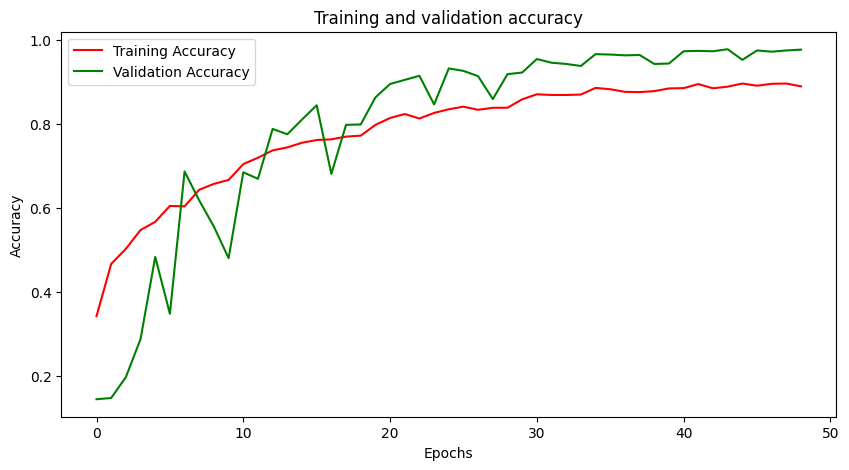

<Figure size 640x480 with 0 Axes>

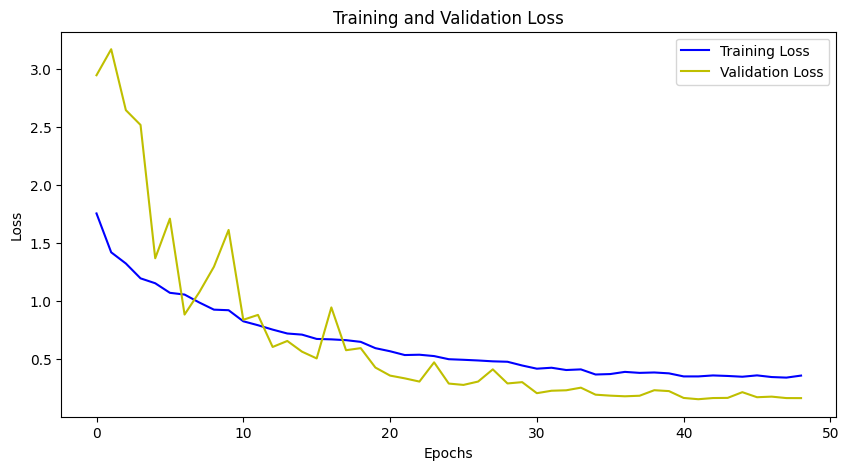

In [ ]:
model_history = history.history

acc = model_history['accuracy']
val_acc = model_history['val_accuracy']
loss = model_history['loss']
val_loss = model_history['val_loss']

epochs = history.epoch

plot_acc_loss(acc, val_acc, loss, val_loss, epochs)

### 5- Model Evaluation

In [ ]:
# Save the model
model.save('teeth_classification_model.h5')

In [ ]:
#load model
model = load_model('teeth_classification_model.h5')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,940,745 (49.37 MB)

 Trainable params: 12,940,039 (49.36 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
#evaluate model
test_datagen = ImageDataGenerator(rescale=1/255.)
test_generator= test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
loss, accuracy = model.evaluate(test_generator)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Found 1028 images belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9648 - loss: 0.1552
Test loss: 0.1412258744239807
Test accuracy: 0.9708171486854553
